# Assignment  2

Kexin Yang

April 22, 2024

## 1 Introduction

Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}[\textbf{Payoff}(S_T)]
$$

for the appropriate form of payoff, to consider **Asian** and **Lookback** options.

Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data

\begin{aligned}
    Today's \ stock \ price \ S_0 &= 100 \\
    Strike \ E &= 100 \\
    Time \ to \ expiry \ (T - t) &= 1 \ year \\
    Volatility \ \sigma &= 20\% \\
    Constant \ risk\text{--}free \ interest \ rate \ r &= 5\%
\end{aligned}

Then vary the data to see the affect on the option price.

## 2 Methodology

### 2.1 Asset Pricing

Following Black-Scholes-Merton where the underlying follows under risk neutrality, a geometric Brownian motion with a stochastic differential equation (SDE) is given to simulate the asset price at maturity $S_T$ as
$$
    dS_t = \mu S_t dt + \sigma S_t dW_t
$$
where $S_t$ is the price of the underlying at time $t$, $\sigma$ is constant volatility, $r$ is the constant risk-free interest rate and $W$ is the brownian motion.

Applying **Euler-Maruyama** discretization of SDE, we get
$$
    S_{t+\delta t} = S_t * (1 + r\delta t + \sigma \sqrt{\delta t} w_t)
$$
It is often more convenient to express in time stepping form
$$
    S_{t+\delta t} = S_t * e^{((r-\frac{1}{2} \sigma^2)\delta t + \sigma \sqrt{\delta t} w_t)}
$$
The variable $w$ is a standard normally distributed random variable, $0 < \delta t < T$, time interval. It also holds $0 < t ≤ T$ with $T$, the final time horizon.

### 2.2 Variance Reduction

Monte Carlo methods are simulation algorithms to estimate a numerical quantity in a statistical model. There are few methods that provide for high accurary. Variance reduction techniques such as a) antithetic variates, b) control variates and c) moment matching are widely adopted.

In antithetic variates, we try to reduce the variance by introducing negative dependence between pairs of random draws while in moment matching, we correct the set of standard normal pseudo-random numbers generated by Python to match the first two moments correctly. In control variates method, we exploit information about the errors in estimates of known quantities to reduce the error of an estimate of an unknown quantity. 

Python functions generate pseudorandom numbers that might exhibit the expected statistical behaviour. We try to achieve the desired property by employing variance reduction techniques. 

### 2.3 Option Price

To price an option using a Monte Carlo simulation we use a risk-neutral valuation, where the fair value for a derivative is the expected value of its future payoff. So at any date before maturity, denoted by $t$, the option's value is the present value of the expectation of its payoff at maturity, $T$.

$$
    C = PV(E[payoff])
$$

Under the risk-neutral framework, we assume the asset is going to earn, on average, the risk-free interest rate. Hence, the option value at time  t  would simply be the discounted value of the expected payoff.

$$
    C = e^{-r(T-t)}(E[payoff])
$$

### 2.4 Asian Option

An Asian option is an option where the payoff depends on the average price of the underlying asset over a certain period of time. 

#### 2.4.1 Types of Average

Basically, there are four types of Average.

- Continuous arithmetic average

$$
    A = \frac{1}{T} \int_0^T S(\tau)d\tau
$$

- Continuous geometric average

$$
    A = e^{\frac{1}{t} \int_0^t lnS(\tau)d\tau}
$$

- Discrete arithmetic averages

$$
    A = \frac{1}{T} \sum \limits_{i = 1}^T S(t_i)
$$

- Discrete geometric average

$$
    A = e^{\frac{1}{T} \sum \limits_{i = 1}^T lnS(t_i)}
$$


As we have already discretized the asset price changes using the Euler-Maruyama method, we will subsequently use the discrete methods to calculate the averages.

#### 2.4.2 Type of Payoff
The payoff types can be classified into **fixed strike** and **floating strike**. These classifications work as follows.

| Classification      | Payoff Formula  |
|---------------------|-----------------|
| fixed strike call | $$max(A-E, 0)$$ |
| fixed strike put  | $$max(E-A, 0)$$ |
| floating strike call   | $$max(S_T-A, 0)$$ |
| floating strike put    | $$max(A-S_T, 0)$$ |

where $E$ is the strike price, $S_T$ is the floating strike price at maturity T and $A$ is the average price of the underlying asset over the life of the option. 

### 2.5 Lookback Option
Lookback options have a payoff that depends on the realised maximum or minimum of the underlying asset over some period prior to expiry.

#### 2.5.1 Types of Maximum and Minimum

- Continuous maximum

$$
    M = \mathop{max}\limits_{0 \le \tau \le t}(S(\tau))
$$

- Discrete maximum

$$
    M_i = max(S(t_i), M_{i-1})
$$
- Continuous minimum

$$
    M = \mathop{min}\limits_{0 \le \tau \le t}(S(\tau))
$$

- Discrete minimum

$$
    M_i = min(S(t_i), M_{i-1})
$$

#### 2.5.2  Types of Payoff

The payoff types can be classified into **fixed strike** and **floating strike**. These classifications work as follows.


| Classification      | Payoff Formula  |
|---------------------|-----------------|
| fixed strike call   | $$max(M-E, 0)$$ |
| fixed strike put    | $$max(E-M, 0)$$ |
| floating strike call| $$max(S_T-M, 0)$$ |
| floating strike put | $$max(M-S_T, 0)$$ |

where 
for fixed strike call, M is the realised maximum, for fixed strike put, M is the realised minimum, for floating strike call, M is the realised minimum of the asset price, and for floating strike put, M is the realised maximum of the asset price. Additionally, $S_T$ is the floating striking price at Maturity T, and $E$ is the strike price.

## 3 Experiments

### 3.1 Monte Carlo Simulation
Now simulating price paths by creating a seperate path function

In [236]:
# Importing libraries
import pandas as pd
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
# Set max row to 300
pd.set_option('display.max_rows', 300)

In [237]:
# define simulation function
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    # set the seed
    random.seed(2023)
    # read the params
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    
    # define dt
    dt = T/t
    
    # simulate path
    S = zeros((t,n))
    S[0] = S0
    
    for i in range(0, t-1):
        w = random.standard_normal(n)
        S[i+1] = S[i] * (1+ r*dt + sigma*sqrt(dt)*w)
        
    return S

In [238]:
# Assign simulated price path to dataframe for analysis and plotting
price_path = pd.DataFrame(simulate_path(100,0.05,0.2,1,252,100000))

# Verify the generated price paths
price_path.head()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.916466,99.611029,98.757603,100.317489,99.891132,98.581948,103.364080,101.834833,100.144446,96.087080,...,100.526533,98.860239,98.837148,100.039456,98.913105,99.580159,99.246204,99.383916,98.362717,100.002582
2,101.102047,99.252871,98.060186,100.326270,98.603518,100.717457,104.176433,100.222994,101.468809,95.026936,...,101.555214,97.144692,99.130006,100.251700,97.617909,99.474348,98.328044,100.179019,98.775283,99.668132
3,100.572272,100.383399,98.151705,100.305081,100.957863,101.003838,105.040394,96.817626,100.584172,93.812262,...,100.687368,95.671818,98.864215,100.339384,98.261258,101.356891,97.348343,100.076692,98.885967,98.173543
4,100.103597,100.482743,99.225147,100.341161,100.908313,100.437038,104.973611,96.873934,99.199344,92.857468,...,103.588192,96.954031,100.491272,99.724911,98.236881,100.712394,97.737062,99.770981,97.046760,97.968690


### 3.2 Asian Option Pricing

#### 3.2.1 fixed strike arthmetic average option
Firstly, we’ll now price a fixed strike arthmetic average option using Monte Carlo simulation.

The payoff of the options is given by
$$
C_T=max(0, \frac{1}{T} \sum \limits_{i = 1}^T S(t_i)-E)
$$

$$
C_T=max(0, S_{Avg} - E)
$$

According to 2.2 option pricing which we have talked about, we could get

$$
    C = PV(E[max(S_{Avg} - E)])
$$

Then, under the risk-neutral framework, we could get

$$
    C = e^{-r(T-t)}(E[max(S_{Avg} - E)])
$$

Similarly, we could get 
$$
P = e^{-r(T-t)}(E[max(E - S_{Avg})])
$$

In [239]:
# Call the simulation function
S = simulate_path(100,0.05,0.2,1,252,100000)

# Define parameters
E = 100; r = 0.05; T=1

# Average price
A = S.mean(axis=0)

C0_fixed_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, A-E))
P0_fixed_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, E-A))

# Print the values
print(f"Asian Call Option Value (fixed strike arthmetic average option) is {C0_fixed_strike_arthmetic_average_option:0.4f}")
print(f"Asian Put Option Value (fixed strike arthmetic average option)is {P0_fixed_strike_arthmetic_average_option:0.4f}")

Asian Call Option Value (fixed strike arthmetic average option) is 5.7777
Asian Put Option Value (fixed strike arthmetic average option)is 3.3600


#### 3.2.2 floating strike arthmetic average option
Secondly, we’ll now price a floating strike arthmetic average option using Monte Carlo simulation.

The payoff of the options is given by
$$
C_T=max(0, S_T-\frac{1}{T} \sum \limits_{i = 1}^T S(t_i))
$$

$$
C_T=max(0, S_T - S_{Avg})
$$

According to 2.2 option pricing which we have talked about, we could get

$$
    C = PV(E[max(S_T - S_{Avg})])
$$

Then, under the risk-neutral framework, we could get

$$
    C = e^{-r(T-t)}(E[max(S_T - S_{Avg})])
$$

Similarly, we could get 
$$
P = e^{-r(T-t)}(E[max(S_{Avg} - S_T)])
$$

In [240]:
# Call the simulation function
S = simulate_path(100,0.05,0.2,1,252,100000)

# Define parameters
E = 100; r = 0.05; T=1

# Average price
A = S.mean(axis=0)

C0_floating_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, S[-1]-A))
P0_floating_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, A-S[-1]))

# Print the values
print(f"Asian Call Option Value (floating strike arthmetic average option) is {C0_floating_strike_arthmetic_average_option:0.4f}")
print(f"Asian Put Option Value (floating strike arthmetic average option)is {P0_floating_strike_arthmetic_average_option:0.4f}")

Asian Call Option Value (floating strike arthmetic average option) is 5.8554
Asian Put Option Value (floating strike arthmetic average option)is 3.3799


#### 3.2.3 fixed strike geometric average option
Thirdly, we’ll now price a fixed strike geometric average option using Monte Carlo simulation.

The payoff of the options is given by

$$
    C = e^{-r(T-t)}(E[max(S_{Avg} - E)])
$$

$$
P = e^{-r(T-t)}(E[max(E - S_{Avg})])
$$

In [241]:
# Call the simulation function
S = simulate_path(100,0.05,0.2,1,252,100000)

# Define parameters
E = 100; r = 0.05; T=1

# Average price
ln_sum = np.sum(np.log(S), axis=0)

geo_avg = np.exp((1/252) * ln_sum)

A = geo_avg
C0_fixed_strike_geometric_average_option = exp(-r*T) * mean(maximum(0, A-E))
P0_fixed_strike_geometric_average_option = exp(-r*T) * mean(maximum(0, E-A))

# Print the values
print(f"Asian Call Option Value (fixed strike geometric average option) is {C0_fixed_strike_geometric_average_option:0.4f}")
print(f"Asian Put Option Value (fixed strike geometric average option)is {P0_fixed_strike_geometric_average_option:0.4f}")

Asian Call Option Value (fixed strike geometric average option) is 5.5605
Asian Put Option Value (fixed strike geometric average option)is 3.4786


#### 3.2.4 floating strike geometric average option
Finally, we’ll now price a floating strike geometric average option using Monte Carlo simulation.

The payoff of the options is given by

$$
    C = e^{-r(T-t)}(E[max(S_T - S_{Avg})])
$$

$$
P = e^{-r(T-t)}(E[max(S_{Avg} - S_T)])
$$

In [242]:
# Call the simulation function
S = simulate_path(100,0.05,0.2,1,252,100000)

# Define parameters
E = 100; r = 0.05; T=1

# Average price
ln_sum = np.sum(np.log(S), axis=0)

geo_avg = np.exp((1/252) * ln_sum)

A = geo_avg
C0_floating_strike_geometric_average_option = exp(-r*T) * mean(maximum(0, S[-1]-A))
P0_floating_strike_geometric_average_option = exp(-r*T) * mean(maximum(0, A-S[-1]))

# Print the values
print(f"Asian Call Option Value (floating strike geometric average option) is {C0_floating_strike_geometric_average_option:0.4f}")
print(f"Asian Put Option Value (floating strike geometric average option)is {P0_floating_strike_geometric_average_option:0.4f}")

Asian Call Option Value (floating strike geometric average option) is 6.0651
Asian Put Option Value (floating strike geometric average option)is 3.2538


#### 3.2.5 Displaying fixed strike arthmetic average option pricing results

In [243]:
from tabulate import tabulate
table = [
            ['Asian Call Option Value', C0_fixed_strike_arthmetic_average_option, C0_floating_strike_arthmetic_average_option],
            ['Asian Put Option Value', P0_fixed_strike_arthmetic_average_option, P0_floating_strike_arthmetic_average_option],
        ]

header = ['', 'fixed strike option', 'floating strike option']

print(tabulate(table, headers=header, tablefmt='grid'))

+-------------------------+-----------------------+--------------------------+
|                         |   fixed strike option |   floating strike option |
+=========================+=======================+==========================+
| Asian Call Option Value |               5.77766 |                  5.85538 |
+-------------------------+-----------------------+--------------------------+
| Asian Put Option Value  |               3.35997 |                  3.37989 |
+-------------------------+-----------------------+--------------------------+


#### 3.2.6 Displaying fixed strike geometric average option pricing results

In [244]:
from tabulate import tabulate
table = [
            ['Asian Call Option Value', C0_fixed_strike_geometric_average_option, C0_floating_strike_geometric_average_option],
            ['Asian Put Option Value', P0_fixed_strike_geometric_average_option, P0_floating_strike_geometric_average_option],
        ]

header = ['', 'fixed strike option', 'floating strike option']

print(tabulate(table, headers=header, tablefmt='grid'))

+-------------------------+-----------------------+--------------------------+
|                         |   fixed strike option |   floating strike option |
+=========================+=======================+==========================+
| Asian Call Option Value |               5.56045 |                  6.06514 |
+-------------------------+-----------------------+--------------------------+
| Asian Put Option Value  |               3.47857 |                  3.25384 |
+-------------------------+-----------------------+--------------------------+


### 3.3 Lookback Option Pricing

#### 3.2.1 fixed strike option
Firstly, we’ll now price a fixed strike option using Monte Carlo simulation.

The payoff of the options is given by
$$
C_T=max(0, M-E)
$$

According to 2.2 option pricing which we have talked about, we could get

$$
    C = PV(E[max(M-E)])
$$

Then, under the risk-neutral framework, we could get

$$
    C = e^{-r(T-t)}(E[max(M-E)]) 
$$

where M stands for the realised maximum 

Similarly, we could get 
$$
P = e^{-r(T-t)}(E[max(E-M)])
$$

where M stands for the realised minimum

In [245]:
def look_back_option_prices(S, E, r, T):
    M_max_fixed_strike_option = np.max(S, axis=0)  # Realized maximum for each simulation
    M_min_fixed_strike_option = np.min(S, axis=0)  # Realized minimum for each simulation
    
    # Calculate option prices
    C_lookback_fixed_strike_option = np.exp(-r * T) * np.mean(np.maximum(0, M_max_fixed_strike_option - E))
    P_lookback_fixed_strike_option = np.exp(-r * T) * np.mean(np.maximum(0, E - M_min_fixed_strike_option))
    
    return C_lookback_fixed_strike_option, P_lookback_fixed_strike_option, M_max_fixed_strike_option, M_min_fixed_strike_option

# Call the simulation function
S = simulate_path(100, 0.05, 0.2, 1, 252, 100000)

# Define parameters
E = 100
r = 0.05
T = 1

# Calculate look back option prices and get max/min values
C_lookback_fixed_strike_option, P_lookback_fixed_strike_option, M_max_fixed_strike_option, M_min_fixed_strike_option = look_back_option_prices(S, E, r, T)

# Print the option prices
print(f"Look Back Call Option Price: {C_lookback_fixed_strike_option:0.4f}")
print(f"Look Back Put Option Price: {P_lookback_fixed_strike_option:0.4f}")


Look Back Call Option Price: 18.3384
Look Back Put Option Price: 11.7360


#### 3.2.2 floating strike option
Secondly, we’ll now price a floating strike option using Monte Carlo simulation.

The payoff of the options is given by
$$
C_T=max(0, S_T-M)
$$

According to 2.2 option pricing which we have talked about, we could get

$$
    C = PV(E[max(S_T-M)])
$$

Then, under the risk-neutral framework, we could get

$$
    C = e^{-r(T-t)}(E[max(S_T-M)]) 
$$

where M stands for the realised minimum of the asset price

Similarly, we could get 
$$
P = e^{-r(T-t)}(E[max(M-S_T)])
$$

where M stands for the realised maximum of the asset price

In [246]:
# Calculate look back option prices
def look_back_option_prices(S, E, r, T):
    M_max_floating_strike_option = np.max(S, axis=0)  # Realized maximum for each simulation
    M_min_floating_strike_option = np.min(S, axis=0)  # Realized minimum for each simulation
    
    # Calculate option prices
    C_lookback_floating_strike_option = exp(-r * T) * np.mean(np.maximum(0, S[-1] - M_min_floating_strike_option))
    P_lookback_floating_strike_option = exp(-r * T) * np.mean(np.maximum(0, M_max_floating_strike_option - S[-1]))
    
    return C_lookback_floating_strike_option, P_lookback_floating_strike_option

# Call the simulation function
S = simulate_path(100, 0.05, 0.2, 1, 252, 100000)

# Define parameters
E = 100
r = 0.05
T = 1

# Calculate look back option prices
C_lookback_floating_strike_option, P_lookback_floating_strike_option = look_back_option_prices(S, E, r, T)

# Print the values
print(f"Look Back Call Option Price: {C_lookback_floating_strike_option:0.4f}")
print(f"Look Back Put Option Price: {P_lookback_floating_strike_option:0.4f}")

Look Back Call Option Price: 16.6291
Look Back Put Option Price: 13.4453


#### 3.2.3 Displaying floating strike option pricing results


In [247]:
from tabulate import tabulate
table = [
            ['Look Back Call Option', C_lookback_fixed_strike_option, C_lookback_floating_strike_option],
            ['Look Back Put Option', P_lookback_fixed_strike_option, P_lookback_floating_strike_option],
        ]

header = ['', 'fixed strike option', 'floating strike option']

print(tabulate(table, headers=header, tablefmt='grid'))

+-----------------------+-----------------------+--------------------------+
|                       |   fixed strike option |   floating strike option |
+=======================+=======================+==========================+
| Look Back Call Option |               18.3384 |                  16.6291 |
+-----------------------+-----------------------+--------------------------+
| Look Back Put Option  |               11.736  |                  13.4453 |
+-----------------------+-----------------------+--------------------------+


## 4 Discussion

### 4.1 Design

Vary the variables to see the affect on the option price.

| Variables               | Range                 |
|-------------------------|-----------------------|
| Strike                  | range(50, 200, 10) |
| Time to Expiry          | range(0.5, 3, 0.5)   |
| Volatility              | range(0.1, 0.5, 0.05)    |
| Risk-Free Interest Rate | range(0, 1, 0.02)       |


### 4.2 Strike

#### 4.2.1 Asian Option
We do not discuss the floating strike call option and put option because their payoffs are not related to the strike price.
##### 4.2.1.1 fixed strike arithmetic average option
We are now varying the strike price of the fixed strike arithmetic average option for Asian options from 50 with intervals of 10 up to 200 (excluding 200), in order to observe the changes in option prices.

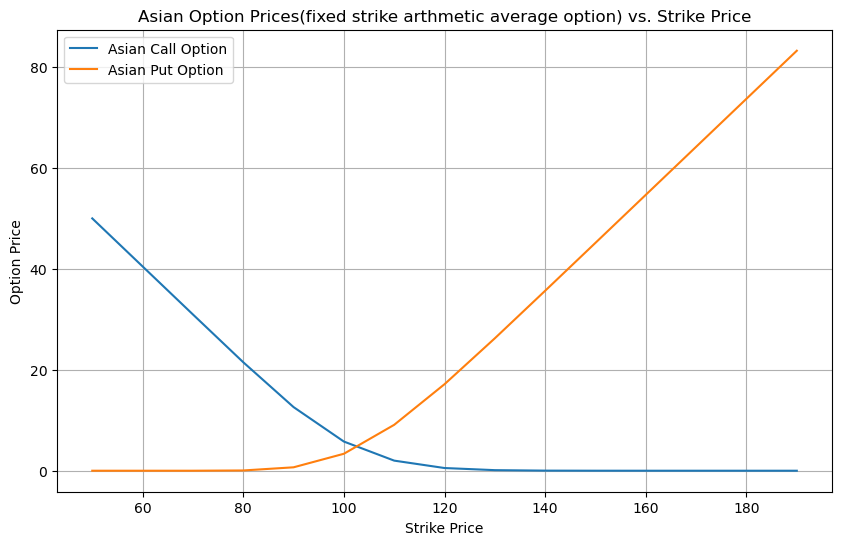

In [248]:
import matplotlib.pyplot as plt

# Define function to calculate option prices
def calculate_option_prices(S, E, r, T):
    A = S.mean(axis=0)
    C_fixed_strike_arthmetic_average_option = np.exp(-r*T) * np.mean(np.maximum(0, A-E))
    P_fixed_strike_arthmetic_average_option = np.exp(-r*T) * np.mean(np.maximum(0, E-A))
    return C_fixed_strike_arthmetic_average_option, P_fixed_strike_arthmetic_average_option

# Define parameters and range
strike_range = range(50, 200, 10)
E = 100
r = 0.05
T = 1
n_sims = 100000
timesteps = 252

# Define parameters and range
C_fixed_strike_arthmetic_average_options = []
P_fixed_strike_arthmetic_average_options = []

# Calculate option prices for different strikes
for strike in strike_range:
    S = simulate_path(100, 0.05, 0.2, 1, 252, 100000)
    C_fixed_strike_arthmetic_average_option, P_fixed_strike_arthmetic_average_option = calculate_option_prices(S, strike, r, T)
    C_fixed_strike_arthmetic_average_options.append(C_fixed_strike_arthmetic_average_option)
    P_fixed_strike_arthmetic_average_options.append(P_fixed_strike_arthmetic_average_option)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(strike_range, C_fixed_strike_arthmetic_average_options, label='Asian Call Option')
plt.plot(strike_range, P_fixed_strike_arthmetic_average_options, label='Asian Put Option')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Asian Option Prices(fixed strike arthmetic average option) vs. Strike Price')
plt.legend()
plt.grid(True)
plt.show()

Observations:
    1. Under arithmetic averaging, Asian call option prices decrease gradually as the strike price increases. Specifically, they tend to approach zero when the strike price is at 130. On the other hand, under arithmetic averaging, Asian put option prices increase gradually as the strike price increases, and they tend to exceed zero when the strike price is at 80.
    2. Strike Price Sensitivity: The change in Asian option prices with increasing strike prices reflects sensitivity to the strike price. When the strike price exceeds a certain threshold (e.g., 130), the price of Asian call options may approach zero, indicating caution in the market regarding high strike prices. Conversely, when the strike price is below a certain threshold (e.g., 80), the price of Asian call options may gradually become valuable, signaling market optimism about low strike prices.

##### 4.2.1.2 fixed strike geometric average option
We are now varying the strike price of the fixed strike geometric average option for Asian options from 50 with intervals of 10 up to 200 (excluding 200), in order to observe the changes in option prices.

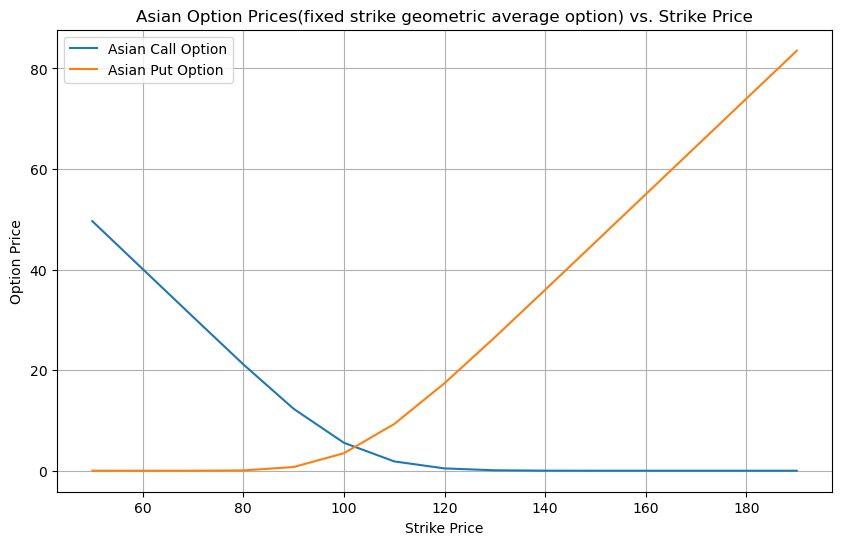

In [249]:
# Define function to calculate option prices
def calculate_option_prices(S, E, r, T):
    ln_sum = np.sum(np.log(S), axis=0)
    geo_avg = np.exp((1/252) * ln_sum)
    A = geo_avg
    C_fixed_strike_geometric_average_option = np.exp(-r*T) * np.mean(np.maximum(0, A-E))
    P_fixed_strike_geometric_average_option = np.exp(-r*T) * np.mean(np.maximum(0, E-A))
    return C_fixed_strike_geometric_average_option, P_fixed_strike_geometric_average_option

# Define parameters and range
strike_range = range(50, 200, 10)
E = 100
r = 0.05
T = 1
n_sims = 100000
timesteps = 252

# List to store option prices
C_fixed_strike_geometric_average_options = []
P_fixed_strike_geometric_average_options = []

# Calculate option prices for different strikes
for strike in strike_range:
    S = simulate_path(100, 0.05, 0.2, 1, 252, 100000)
    C_fixed_strike_geometric_average_option, P_fixed_strike_geometric_average_option = calculate_option_prices(S, strike, r, T)
    C_fixed_strike_geometric_average_options.append(C_fixed_strike_geometric_average_option)
    P_fixed_strike_geometric_average_options.append(P_fixed_strike_geometric_average_option)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(strike_range, C_fixed_strike_geometric_average_options, label='Asian Call Option')
plt.plot(strike_range, P_fixed_strike_geometric_average_options, label='Asian Put Option')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Asian Option Prices(fixed strike geometric average option) vs. Strike Price')
plt.legend()
plt.grid(True)
plt.show()


Observations:
    1. Under geometric averaging, Asian call option prices decrease gradually as the strike price increases. Specifically, they tend to approach zero when the strike price is at 130. On the other hand, under geometric averaging, Asian put option prices increase gradually as the strike price increases, and they tend to exceed zero when the strike price is at 80.
    2. Strike Price Sensitivity: The change in Asian option prices with increasing strike prices reflects sensitivity to the strike price. When the strike price exceeds a certain threshold (e.g., 130), the price of Asian call options may approach zero, indicating caution in the market regarding high strike prices. Conversely, when the strike price is below a certain threshold (e.g., 80), the price of Asian call options may gradually become valuable, signaling market optimism about low strike prices.

##### 4.2.1.3 floating strike option
As the payoff of floating strike options in Asian options are    
$$
C = e^{-r(T-t)}(E[max(S_T-M)])
$$
$$
P = e^{-r(T-t)}(E[max(M-S_T)])
$$ which are unrelated to the strike price, we will not discuss them here.

#### 4.2.2 Lookback Option
We are now varying the strike price of the lookback options from 50 with intervals of 10 up to 200 (excluding 200), in order to observe the changes in option prices.
##### 4.2.2.1 fixed strike option

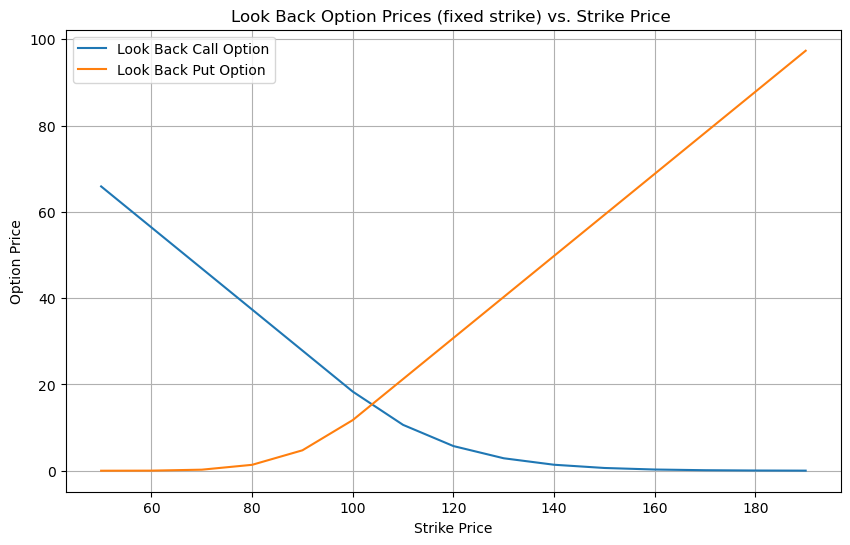

In [250]:
import matplotlib.pyplot as plt

def calculate_option_prices(S, E, r, T, strike):
    M_max_fixed_strike_option = np.max(S, axis=0)
    M_min_fixed_strike_option = np.min(S, axis=0)
    
    C_lookback_fixed_strike_option = np.exp(-r * T) * np.mean(np.maximum(0, M_max_fixed_strike_option - strike))
    P_lookback_fixed_strike_option = np.exp(-r * T) * np.mean(np.maximum(0, strike - M_min_fixed_strike_option))
    
    return C_lookback_fixed_strike_option, P_lookback_fixed_strike_option

# Define parameters and range
strike_range = range(50, 200, 10)
E = 100
r = 0.05
T = 1

# Lists to store option prices
C_lookback_fixed_strike_options = []
P_lookback_fixed_strike_options = []

# Calculate option prices for different strikes
for strike in strike_range:
    C_lookback_fixed_strike_option, P_lookback_fixed_strike_option = calculate_option_prices(S, E, r, T, strike)
    C_lookback_fixed_strike_options.append(C_lookback_fixed_strike_option)
    P_lookback_fixed_strike_options.append(P_lookback_fixed_strike_option)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(strike_range, C_lookback_fixed_strike_options, label='Look Back Call Option')
plt.plot(strike_range, P_lookback_fixed_strike_options, label='Look Back Put Option')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Look Back Option Prices (fixed strike) vs. Strike Price ')
plt.legend()
plt.grid(True)
plt.show()

Observations: 1. Lookback call options show a gradual decline in option prices as the strike price increases. Additionally, the option price tends to approach zero when the strike price reaches 160. On the other hand, lookback put options exhibit a gradual increase in option prices as the strike price increases, and the option price gradually exceeds zero when the strike price is around 70. 2. In terms of Lookback Call Option, option price decreases as strike price increases, nearing zero around 160, which shows caution towards high strikes. In terms of Lookback Put Option, price increases as strike price increases, exceeding zero around 70, which indicates optimism towards low strikes.

##### 4.2.2.2 floating strike option

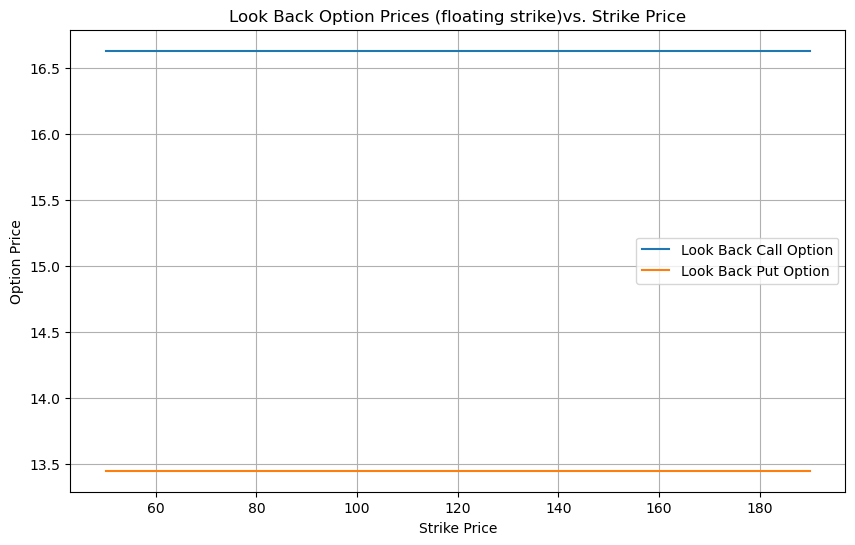

In [251]:
def calculate_option_prices(S, r, T, strike):
    M_max_floating_strike_option = np.max(S, axis=0)
    M_min_floating_strike_option = np.min(S, axis=0)
    
    C_lookback_floating_strike_option = np.exp(-r * T) * np.mean(np.maximum(0, S[-1] - M_min_floating_strike_option))
    P_lookback_floating_strike_option = np.exp(-r * T) * np.mean(np.maximum(0, M_max_floating_strike_option - S[-1]))
    
    return C_lookback_floating_strike_option, P_lookback_floating_strike_option

# Define parameters and range
strike_range = range(50, 200, 10)
E = 100
r = 0.05
T = 1

# Lists to store option prices
C_lookback_floating_strike_options = []
P_lookback_floating_strike_options = []

# Calculate option prices for different strikes
for strike in strike_range:
    C_lookback_floating_strike_option, P_lookback_floating_strike_option = calculate_option_prices(S, r, T, strike)
    C_lookback_floating_strike_options.append(C_lookback_floating_strike_option)
    P_lookback_floating_strike_options.append(P_lookback_floating_strike_option)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(strike_range, C_lookback_floating_strike_options, label='Look Back Call Option')
plt.plot(strike_range, P_lookback_floating_strike_options, label='Look Back Put Option')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Look Back Option Prices (floating strike)vs. Strike Price')
plt.legend()
plt.grid(True)
plt.show()

Observations:
    We can see that lookback floating strike options are unrelated to the strike price.

### 4.3 Time to Expiry
#### 4.3.1 Asian Option
Now we will study how Asian option prices change with the time horizon. The range of the time horizon varies from 0.5 to 3, increasing at intervals of 0.5. The Asian options studied include fixed strike option and floating strike option. We will discuss the options from both arithmetic and geometric average perspectives.
##### 4.3.1.1 arthmetic average 

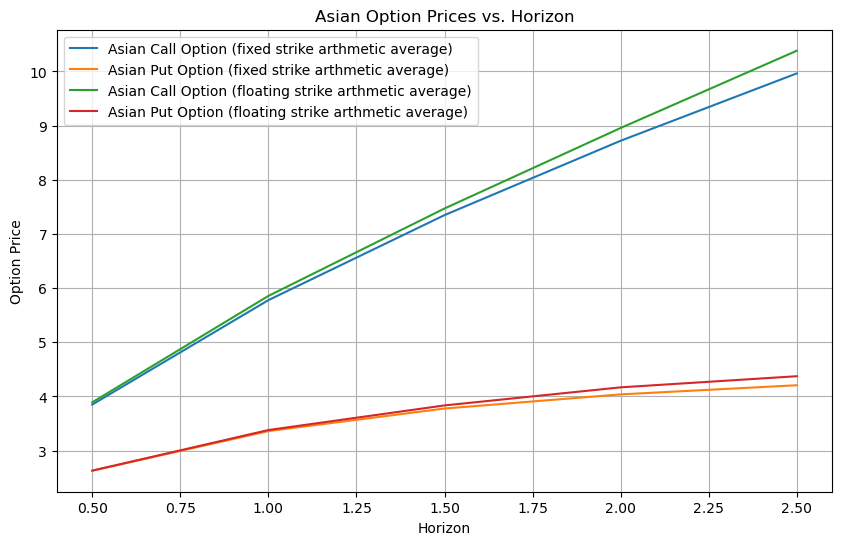

In [252]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, mean, maximum, sqrt, zeros
from numpy.random import standard_normal  # Importing standard_normal from numpy.random

# Define simulation function
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    np.random.seed(2023)  # Use np.random.seed for NumPy random generator
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    dt = T / t
    
    # Simulate path
    S = zeros((t, n))
    S[0] = S0
    
    for i in range(t - 1):
        w = standard_normal(n)  # Use standard_normal from numpy.random
        S[i + 1] = S[i] * (1 + r * dt + sigma * sqrt(dt) * w)
        
    return S

# Define function to calculate option prices
def calculate_option_prices(S, E, r, T):
    A = S.mean(axis=0)
    C_fixed_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, A-E))
    P_fixed_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, E-A))
    C_floating_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, S[-1]-A))
    P_floating_strike_arthmetic_average_option = exp(-r*T) * mean(maximum(0, A-S[-1]))
    return C_fixed_strike_arthmetic_average_option, P_fixed_strike_arthmetic_average_option, C_floating_strike_arthmetic_average_option, P_floating_strike_arthmetic_average_option

# Define parameters and ranges
horizon_range = np.arange(0.5, 3.0, 0.5)
strike = 100
r = 0.05
E = 100
n_sims = 100000

# Store option prices
C_fixed_strike_arthmetic_average_options = []
P_fixed_strike_arthmetic_average_options = []
C_floating_strike_arthmetic_average_options = []
P_floating_strike_arthmetic_average_options = []

# Calculate option prices for different horizons
for horizon in horizon_range:
    timesteps = int(252 * horizon)
    S = simulate_path(100, 0.05, 0.2, horizon, timesteps, n_sims)
    C_fixed_strike_arthmetic_average_option, P_fixed_strike_arthmetic_average_option, C_floating_strike_arthmetic_average_option, P_floating_strike_arthmetic_average_option = calculate_option_prices(S, E, r, horizon)
    C_fixed_strike_arthmetic_average_options.append(C_fixed_strike_arthmetic_average_option)
    P_fixed_strike_arthmetic_average_options.append(P_fixed_strike_arthmetic_average_option)
    C_floating_strike_arthmetic_average_options.append(C_floating_strike_arthmetic_average_option)
    P_floating_strike_arthmetic_average_options.append(P_floating_strike_arthmetic_average_option)
# Plot option prices
plt.figure(figsize=(10, 6))
plt.plot(horizon_range, C_fixed_strike_arthmetic_average_options, label='Asian Call Option (fixed strike arthmetic average)')
plt.plot(horizon_range, P_fixed_strike_arthmetic_average_options, label='Asian Put Option (fixed strike arthmetic average)')
plt.plot(horizon_range, C_floating_strike_arthmetic_average_options, label='Asian Call Option (floating strike arthmetic average)')
plt.plot(horizon_range, P_floating_strike_arthmetic_average_options, label='Asian Put Option (floating strike arthmetic average)')
plt.xlabel('Horizon')
plt.ylabel('Option Price')
plt.title('Asian Option Prices vs. Horizon')
plt.legend()
plt.grid(True)
plt.show()


Observations:
    1. As the time horizon increases, under the arithmetic average, both fixed strike and floating strike Asian options increase in value. 2. In terms of call option, the value of floating strike is always higher than fixed strike. Additionally, in terms of put option, the value of floating strike is always higher than fixed strike. This may indicate that the market holds a higher degree of preference for options with more flexibility

##### 4.3.1.2 geometric average

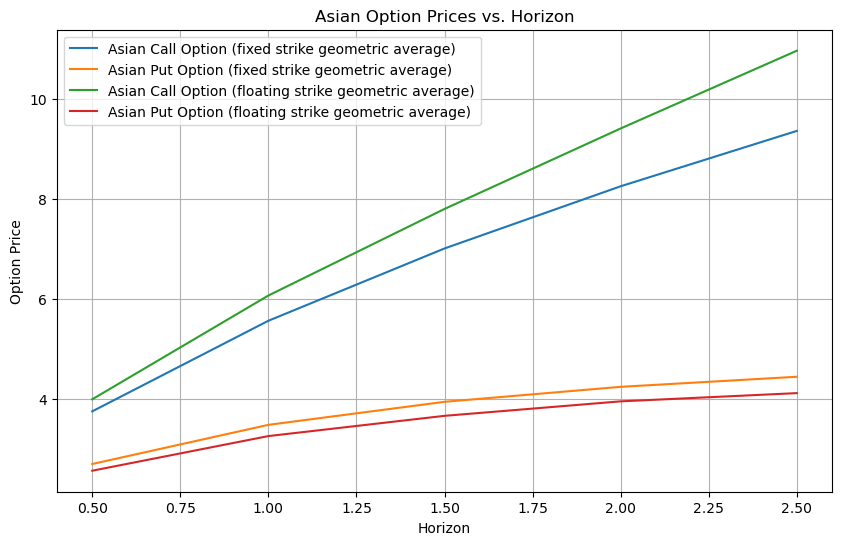

In [253]:
# Define simulation function
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    np.random.seed(2023)  # Use np.random.seed for NumPy random generator
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    dt = T / t
    
    # Simulate path
    S = zeros((t, n))
    S[0] = S0
    
    for i in range(t - 1):
        w = standard_normal(n)  # Use standard_normal from numpy.random
        S[i + 1] = S[i] * (1 + r * dt + sigma * sqrt(dt) * w)
        
    return S

# Define function to calculate option prices
def calculate_option_prices(S, E, r, T):
    ln_sum = np.sum(np.log(S), axis=0)
    geo_avg = np.exp((1 / S.shape[0]) * ln_sum)
    A = geo_avg
    C_fixed_strike_geometric_average_option = exp(-r * T) * mean(maximum(0, A - E))
    P_fixed_strike_geometric_average_option = exp(-r * T) * mean(maximum(0, E - A))
    C_floating_strike_geometric_average_option = exp(-r * T) * mean(maximum(0, S[-1] - A))
    P_floating_strike_geometric_average_option = exp(-r * T) * mean(maximum(0, A - S[-1]))
    return C_fixed_strike_geometric_average_option, P_fixed_strike_geometric_average_option, C_floating_strike_geometric_average_option, P_floating_strike_geometric_average_option

# Define parameters and ranges
horizon_range = np.arange(0.5, 3.0, 0.5)
strike = 100
r = 0.05
E = 100
n_sims = 100000

# Store option prices
C_fixed_strike_geometric_average_options = []
P_fixed_strike_geometric_average_options = []
C_floating_strike_geometric_average_options = []
P_floating_strike_geometric_average_options = []

# Calculate option prices for different horizons
for horizon in horizon_range:
    timesteps = int(252 * horizon)
    S = simulate_path(100, 0.05, 0.2, horizon, timesteps, n_sims)
    C_fixed_strike_geometric_average_option, P_fixed_strike_geometric_average_option, C_floating_strike_geometric_average_option, P_floating_strike_geometric_average_option = calculate_option_prices(S, E, r, horizon)
    C_fixed_strike_geometric_average_options.append(C_fixed_strike_geometric_average_option)
    P_fixed_strike_geometric_average_options.append(P_fixed_strike_geometric_average_option)
    C_floating_strike_geometric_average_options.append(C_floating_strike_geometric_average_option)
    P_floating_strike_geometric_average_options.append(P_floating_strike_geometric_average_option)
# Plot option prices
plt.figure(figsize=(10, 6))
plt.plot(horizon_range, C_fixed_strike_geometric_average_options, label='Asian Call Option (fixed strike geometric average)')
plt.plot(horizon_range, P_fixed_strike_geometric_average_options, label='Asian Put Option (fixed strike geometric average)')
plt.plot(horizon_range, C_floating_strike_geometric_average_options, label='Asian Call Option (floating strike geometric average)')
plt.plot(horizon_range, P_floating_strike_geometric_average_options, label='Asian Put Option (floating strike geometric average)')
plt.xlabel('Horizon')
plt.ylabel('Option Price')
plt.title('Asian Option Prices vs. Horizon')
plt.legend()
plt.grid(True)
plt.show()


Observations:
    1. As the time horizon increases, under the geometric average, both fixed strike and floating strike Asian options increase in value. 2. In terms of call option, the value of floating strike is always higher than fixed strike. Additionally, in terms of put option, the value of floating strike is always higher than fixed strike. This may indicate that the market holds a higher degree of preference for options with more flexibility

#### 4.3.2 Lookback Option
Now we will study how Lookback option prices change with the time horizon. The range of the time horizon varies from 0.5 to 3 as well, increasing at intervals of 0.5. The Lookback options studied include fixed strike option and floating strike option.

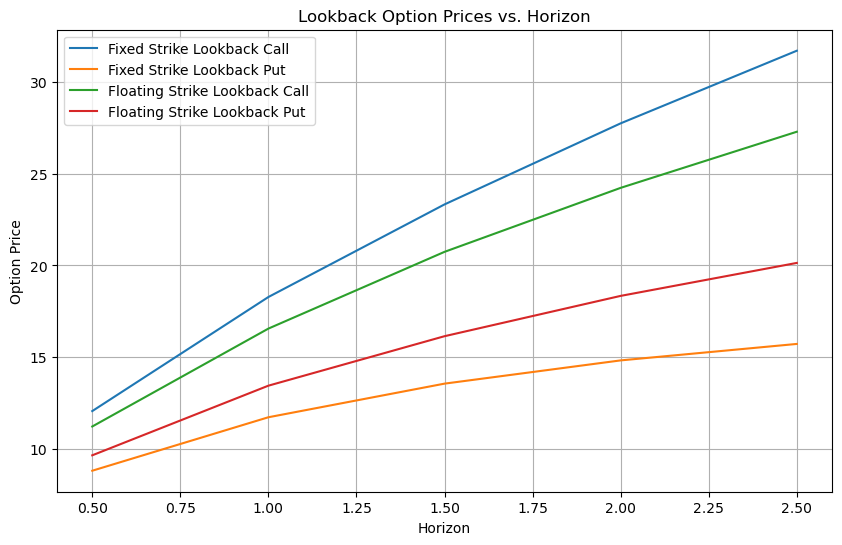

In [254]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, mean, maximum, sqrt, zeros
import random

# Define simulation function
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    random.seed(2023)
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    
    dt = T / t
    S = zeros((t, n))
    S[0] = S0
    
    for i in range(t - 1):
        w = np.array([random.gauss(0, 1) for _ in range(n)])
        S[i+1] = S[i] * (1 + r * dt + sigma * sqrt(dt) * w)
        
    return S

# Calculate lookback option prices
def look_back_option_prices(S, E, r, T, option_type):
    if option_type == 'fixed_strike_lookback_call':
        M_max_option = np.max(S, axis=0)
        option_price = np.exp(-r * T) * np.mean(np.maximum(0, M_max_option - E))
    elif option_type == 'fixed_strike_lookback_put':
        M_min_option = np.min(S, axis=0)
        option_price = np.exp(-r * T) * np.mean(np.maximum(0, E - M_min_option))
    elif option_type == 'floating_strike_lookback_call':
        M_min_option = np.min(S, axis=0)
        option_price = np.exp(-r * T) * np.mean(np.maximum(0, S[-1] - M_min_option))
    elif option_type == 'floating_strike_lookback_put':
        M_max_option = np.max(S, axis=0)
        option_price = np.exp(-r * T) * np.mean(np.maximum(0, M_max_option - S[-1]))
    else:
        option_price = None
        print("Invalid option type!")
    return option_price

# Define parameters and ranges
horizon_range = np.arange(0.5, 3.0, 0.5)
strike = 100
r = 0.05
E = 100
n_sims = 100000
option_types = ['fixed_strike_lookback_call', 
                'fixed_strike_lookback_put',
                'floating_strike_lookback_call', 
                'floating_strike_lookback_put']

# Store option prices
option_prices = {opt_type: [] for opt_type in option_types}

# Calculate option prices for different horizons
for horizon in horizon_range:
    timesteps = int(252 * horizon)
    S = simulate_path(100, 0.05, 0.2, horizon, timesteps, n_sims)
    for opt_type in option_types:
        option_price = look_back_option_prices(S, E, r, horizon, opt_type)
        option_prices[opt_type].append(option_price)

# Plot option prices
plt.figure(figsize=(10, 6))
for opt_type in option_types:
    plt.plot(horizon_range, option_prices[opt_type], label=opt_type.replace('_', ' ').title())
plt.xlabel('Horizon')
plt.ylabel('Option Price')
plt.title('Lookback Option Prices vs. Horizon')
plt.legend()
plt.grid(True)
plt.show()


Observations:
    1. As the time horizon increases, both fixed strike and floating strike Lookback options increase in value. 2. In terms of lookback call option, the value of fixed strike is always higher than floating strike. Additionally, in terms of lookback put option, the value of floating strike is always higher than fixed strike. 3. This phenomenon suggests the performance of different types of Lookback options under various strike price patterns. In Lookback call options, the value of fixed strike options consistently exceeds that of floating strike options. This may reflect the market's higher interest in Call options with fixed strike prices or sensitivity to specific types of risks. On the other hand, in Lookback put options, the value of floating strike options consistently exceeds that of fixed strike options. This may indicate the market's greater interest in downside risk protection or preference for more flexible hedging strategies. These distinctions may be related to market participants' risk preferences and expectations regarding market directions.

### 4.4 Volatility

#### 4.4.1 Asian Option
Now we will study how Asian option prices change with the volatility. The range of the volatility varies from 0.1 to 0.5 (excluding 0.5), increasing at intervals of 0.05. The Asian options studied include fixed strike option and floating strike option. We will discuss the options from both arithmetic and geometric average perspectives.
##### 4.4.1.1 arthmetic average

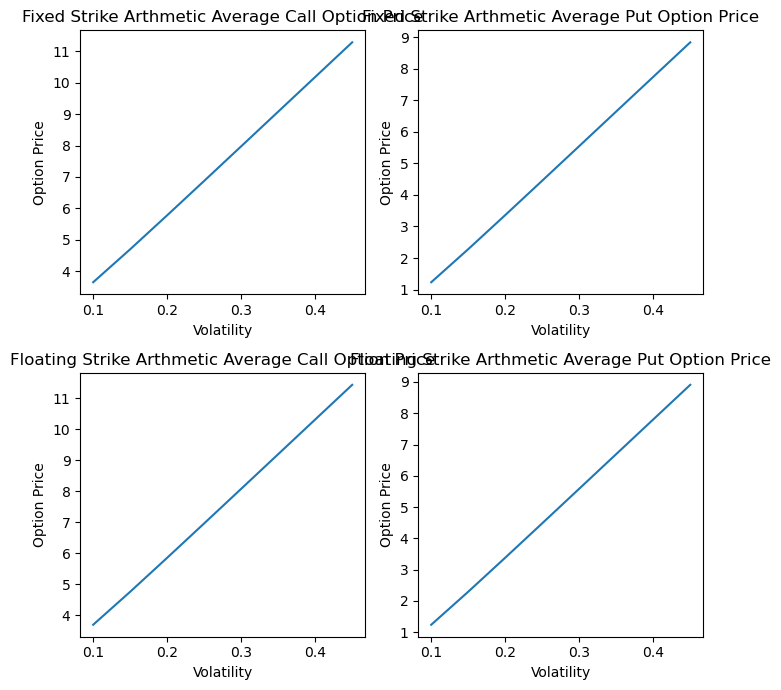

In [255]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, mean, maximum, sqrt, zeros
from numpy.random import standard_normal

# Define simulation function
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    np.random.seed(2023)
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    dt = T / t
    
    S = zeros((t, n))
    S[0] = S0
    
    for i in range(t - 1):
        w = standard_normal(n)
        S[i + 1] = S[i] * (1 + r * dt + sigma * sqrt(dt) * w)
        
    return S

# Define function to calculate option prices
def calculate_option_prices(S, E, r, T, option_type):
    A = S.mean(axis=0)
    if option_type == 'fixed_strike_arthmetic_average_call':
        option_price = exp(-r*T) * mean(maximum(0, A-E))
    elif option_type == 'fixed_strike_arthmetic_average_put':
        option_price = exp(-r*T) * mean(maximum(0, E-A))
    elif option_type == 'floating_strike_arthmetic_average_call':
        option_price = exp(-r*T) * mean(maximum(0, S[-1]-A))
    elif option_type == 'floating_strike_arthmetic_average_put':
        option_price = exp(-r*T) * mean(maximum(0, A-S[-1]))
    else:
        option_price = None
        print("Invalid option type!")
    return option_price

# Define parameters and ranges
volatility_range = np.arange(0.1, 0.5, 0.05)
strike = 100
r = 0.05
E = 100
T = 1
n_sims = 100000
option_types = [
    'fixed_strike_arthmetic_average_call',
    'fixed_strike_arthmetic_average_put',
    'floating_strike_arthmetic_average_call',
    'floating_strike_arthmetic_average_put'
]

# Store option prices
option_prices = {opt_type: [] for opt_type in option_types}

# Calculate option prices for different volatilities
for volatility in volatility_range:
    sigma = volatility
    S = simulate_path(100, 0.05, sigma, 1, 252, n_sims)
    for opt_type in option_types:
        option_price = calculate_option_prices(S, E, r, T, opt_type)
        option_prices[opt_type].append(option_price)

# Plot option prices
plt.figure(figsize=(7,7))

plt.subplot(2, 2, 1)
plt.plot(volatility_range, option_prices['fixed_strike_arthmetic_average_call'])
plt.title('Fixed Strike Arthmetic Average Call Option Price')
plt.xlabel('Volatility')
plt.ylabel('Option Price')

plt.subplot(2, 2, 2)
plt.plot(volatility_range, option_prices['fixed_strike_arthmetic_average_put'])
plt.title('Fixed Strike Arthmetic Average Put Option Price')
plt.xlabel('Volatility')
plt.ylabel('Option Price')

plt.subplot(2, 2, 3)
plt.plot(volatility_range, option_prices['floating_strike_arthmetic_average_call'])
plt.title('Floating Strike Arthmetic Average Call Option Price')
plt.xlabel('Volatility')
plt.ylabel('Option Price')

plt.subplot(2, 2, 4)
plt.plot(volatility_range, option_prices['floating_strike_arthmetic_average_put'])
plt.title('Floating Strike Arthmetic Average Put Option Price')
plt.xlabel('Volatility')
plt.ylabel('Option Price')

plt.tight_layout()
plt.show()


Observations: 1. When volatility increases from 0.1 to 0.5, the prices of both fixed strike and floating strike options increase under arithmetic averaging. 2. This phenomenon indicates that, within the given range of increased volatility (0.1 to 0.5), the prices of Asian options, whether fixed strike or floating strike, increase as volatility rises.

##### 4.4.1.2 geometric average

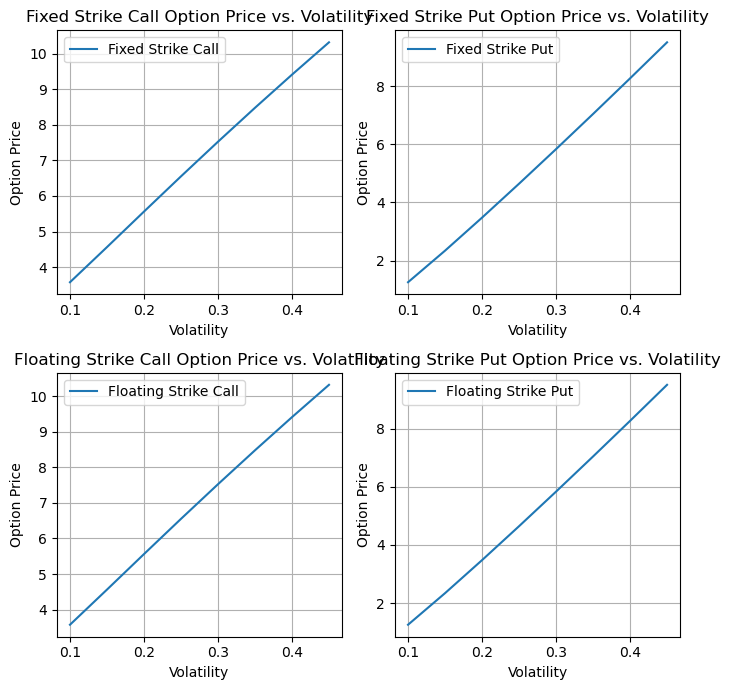

In [256]:
# Calculate geometric average option prices
def calculate_geometric_avg_option_prices(S, E, r, T):
    ln_sum = np.sum(np.log(S), axis=0)
    geo_avg = np.exp((1 / 252) * ln_sum)
    
    A = geo_avg
    C_call = exp(-r * T) * mean(maximum(0, A - E))
    P_put = exp(-r * T) * mean(maximum(0, E - A))
    
    return C_call, P_put

# Define parameters and ranges
volatility_range = np.arange(0.1, 0.5, 0.05)
strike = 100
r = 0.05
E = 100
T = 1
n_sims = 100000

# Lists to store option prices
C_calls_fixed = []
P_puts_fixed = []
C_calls_floating = []
P_puts_floating = []

# Calculate option prices for each volatility
for sigma in volatility_range:
    S_fixed = simulate_path(100, 0.05, sigma, 1, 252, n_sims)
    S_floating = simulate_path(100, 0.05, sigma, 1, 252, n_sims)
    
    C_call_fixed, P_put_fixed = calculate_geometric_avg_option_prices(S_fixed, E, r, T)
    C_calls_fixed.append(C_call_fixed)
    P_puts_fixed.append(P_put_fixed)
    
    C_call_floating, P_put_floating = calculate_geometric_avg_option_prices(S_floating, E, r, T)
    C_calls_floating.append(C_call_floating)
    P_puts_floating.append(P_put_floating)

# Plotting
plt.figure(figsize=(7, 7))

# Plot for fixed strike call option
plt.subplot(2, 2, 1)
plt.plot(volatility_range, C_calls_fixed, label='Fixed Strike Call')
plt.title('Fixed Strike Call Option Price vs. Volatility')
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

# Plot for fixed strike put option
plt.subplot(2, 2, 2)
plt.plot(volatility_range, P_puts_fixed, label='Fixed Strike Put')
plt.title('Fixed Strike Put Option Price vs. Volatility')
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

# Plot for floating strike call option
plt.subplot(2, 2, 3)
plt.plot(volatility_range, C_calls_floating, label='Floating Strike Call')
plt.title('Floating Strike Call Option Price vs. Volatility')
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

# Plot for floating strike put option
plt.subplot(2, 2, 4)
plt.plot(volatility_range, P_puts_floating, label='Floating Strike Put')
plt.title('Floating Strike Put Option Price vs. Volatility')
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Observations: 1. When volatility increases from 0.1 to 0.5, the prices of both fixed strike and floating strike options increase under geometric averaging. 2. This phenomenon indicates that, within the given range of increased volatility (0.1 to 0.5), the prices of Asian options, whether fixed strike or floating strike, increase as volatility rises.

#### 4.4.2 Lookback option

Now we will study how Lookback option prices change with the volatility. The range of the volatility varies from 0.1 to 0.5 (excluding 0.05), increasing at intervals of 0.02. 

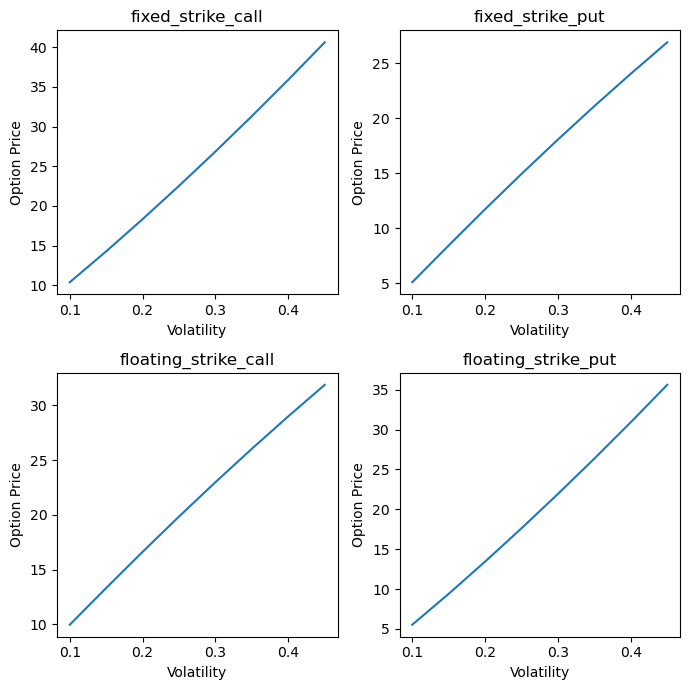

In [257]:
from numpy import exp, mean, maximum, sqrt, zeros
from numpy.random import standard_normal

# Define function to calculate look back option prices for fixed and floating strike
def look_back_option_prices(S, E, r, T):
    M_max_fixed_strike_option = np.max(S, axis=0)  # Realized maximum for each simulation
    M_min_fixed_strike_option = np.min(S, axis=0)  # Realized minimum for each simulation
    
    # Calculate fixed strike option prices
    C_lookback_fixed_strike_option = exp(-r * T) * mean(maximum(0, M_max_fixed_strike_option - E))
    P_lookback_fixed_strike_option = exp(-r * T) * mean(maximum(0, E - M_min_fixed_strike_option))
    
    M_max_floating_strike_option = np.max(S, axis=0)  # Realized maximum for each simulation
    M_min_floating_strike_option = np.min(S, axis=0)  # Realized minimum for each simulation
    
    # Calculate floating strike option prices
    C_lookback_floating_strike_option = exp(-r * T) * mean(maximum(0, S[-1] - M_min_floating_strike_option))
    P_lookback_floating_strike_option = exp(-r * T) * mean(maximum(0, M_max_floating_strike_option - S[-1]))
    
    return C_lookback_fixed_strike_option, P_lookback_fixed_strike_option, C_lookback_floating_strike_option, P_lookback_floating_strike_option

# Define parameters and ranges
volatility_range = np.arange(0.1, 0.5, 0.05)
strike = 100
r = 0.05
E = 100
T = 1
n_sims = 100000

option_types = ['fixed_strike_call', 'fixed_strike_put', 'floating_strike_call', 'floating_strike_put']

# Create subplots for each option type
plt.figure(figsize=(7, 7))

for idx, opt_type in enumerate(option_types):
    option_prices = []
    plt.subplot(2, 2, idx+1)
    plt.title(opt_type)
    plt.xlabel('Volatility')
    plt.ylabel('Option Price')
    
    for sigma in volatility_range:
        S = simulate_path(100, 0.05, sigma, 1, 252, n_sims)
        C_call, P_put, C_put, P_call = look_back_option_prices(S, E, r, T)
        
        if opt_type == 'fixed_strike_call':
            option_price = C_call
        elif opt_type == 'fixed_strike_put':
            option_price = P_put
        elif opt_type == 'floating_strike_call':
            option_price = C_put
        else:
            option_price = P_call
        
        option_prices.append(option_price)
    
    plt.plot(volatility_range, option_prices)

plt.tight_layout()
plt.show()

Observations: 1. When volatility increases from 0.1 to 0.5, the prices of both fixed strike and floating strike options increase. 2. This phenomenon indicates that, within the given range of increased volatility (0.1 to 0.5), the prices of Lookback options, whether fixed strike or floating strike, increase as volatility rises. 2. As volatility increases, the price of fixed strike calls increases at a faster rate than floating strike calls. This phenomenon may reflect that the market is more sensitive to fixed strike call options, especially as volatility increases. This suggests that investors are more inclined to choose options with fixed strike prices to capitalize on the opportunities arising from increased market volatility. Conversely, options with floating strike prices are less sensitive to volatility changes and may be used more for hedging or other specific investment strategies.

### 4.5 Risk-Free Interest Rate

#### 4.5.1 Asian option
Now we will study how Asian option prices change with the risk-free interest rate. The range of the risk-free interest ratevaries from 0 to 1 (excluding 1), increasing at intervals of 0.02. The Asian options studied include fixed strike option and floating strike option. We will discuss the options from both arithmetic and geometric average perspectives.
##### 4.5.1.1 arthmetic average

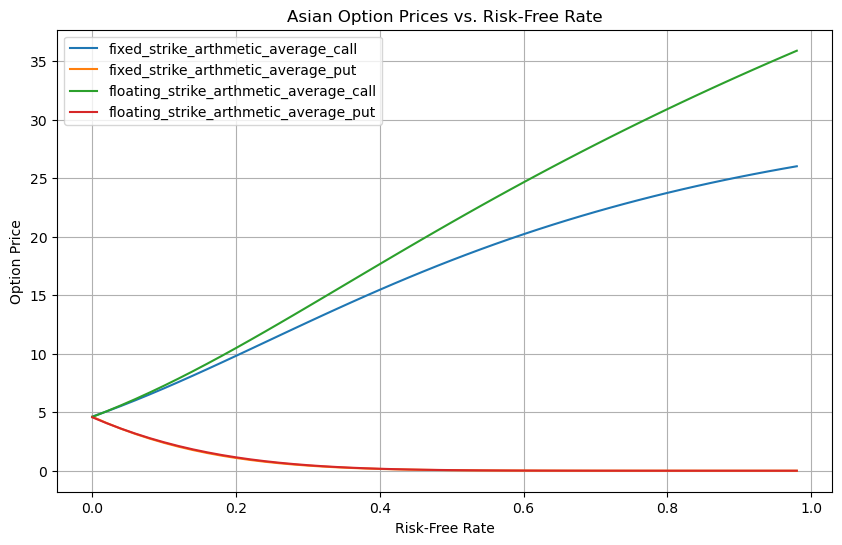

In [258]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, mean, maximum, sqrt, zeros
from numpy.random import standard_normal


# Define function to calculate option prices
def calculate_option_prices(S, E, r, T, option_type):
    A = S.mean(axis=0)
    if option_type == 'fixed_strike_arthmetic_average_call':
        option_price = exp(-r*T) * mean(maximum(0, A-E))
    elif option_type == 'fixed_strike_arthmetic_average_put':
        option_price = exp(-r*T) * mean(maximum(0, E-A))
    elif option_type == 'floating_strike_arthmetic_average_call':
        option_price = exp(-r*T) * mean(maximum(0, S[-1]-A))
    elif option_type == 'floating_strike_arthmetic_average_put':
        option_price = exp(-r*T) * mean(maximum(0, A-S[-1]))
    else:
        option_price = None
        print("Invalid option type!")
    return option_price

# Define parameters and ranges
risk_free_rate_range = np.arange(0, 1, 0.02)
strike = 100
sigma = 0.2
E = 100
T = 1
n_sims = 100000
option_types = [
    'fixed_strike_arthmetic_average_call',
    'fixed_strike_arthmetic_average_put',
    'floating_strike_arthmetic_average_call',
    'floating_strike_arthmetic_average_put'
]

# Store option prices
option_prices = {opt_type: [] for opt_type in option_types}

# Calculate option prices for different risk-free rates
for r in risk_free_rate_range:
    S = simulate_path(100, r, sigma, 1, 252, n_sims)
    for opt_type in option_types:
        option_price = calculate_option_prices(S, E, r, T, opt_type)
        option_prices[opt_type].append(option_price)

# Plot option prices
plt.figure(figsize=(10, 6))

for opt_type in option_types:
    plt.plot(risk_free_rate_range, option_prices[opt_type], label=opt_type)

plt.xlabel('Risk-Free Rate')
plt.ylabel('Option Price')
plt.title('Asian Option Prices vs. Risk-Free Rate')
plt.legend()
plt.grid(True)
plt.show()


Observations: 1.As the risk-free rate increases, under arithmetic averaging, both fixed strike and floating strike Asian call options gradually increase, while Asian put options gradually decrease, ultimately approaching zero when risk-free is approaching 0.45. 2. The growth rate of fixed strike call options is greater than that of floating strike call options. It may indicate investors' preference for specific strike prices. This preference may be related to expectations regarding particular market trends or risk exposures. Therefore, investors tend to choose options with fixed strike prices to take advantage of upward market trends or actively engage in trades with specific risk levels. On the other hand, floating strike call options may be more suitable for hedging strategies or for more flexible responses to different market conditions.

#### 4.5.1.2 geometric average

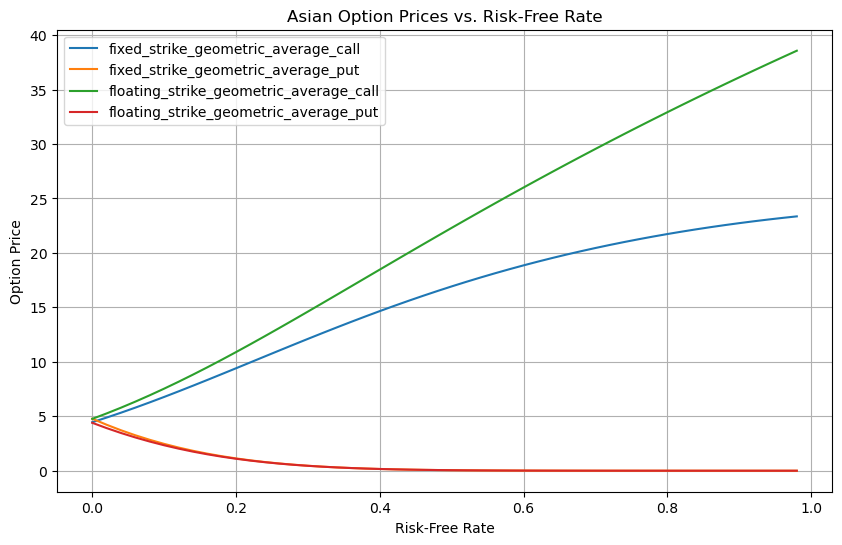

In [259]:
# Define simulation function
# Define function to calculate option prices
def calculate_option_prices(S, E, r, T, option_type):
    ln_sum = np.sum(np.log(S), axis=0)
    geo_avg = np.exp((1/252) * ln_sum)
    
    if option_type == 'fixed_strike_geometric_average_call':
        A = geo_avg
        option_price = exp(-r*T) * mean(maximum(0, A-E))
    elif option_type == 'fixed_strike_geometric_average_put':
        A = geo_avg
        option_price = exp(-r*T) * mean(maximum(0, E-A))
    elif option_type == 'floating_strike_geometric_average_call':
        A = geo_avg
        option_price = exp(-r*T) * mean(maximum(0, S[-1]-A))
    elif option_type == 'floating_strike_geometric_average_put':
        A = geo_avg
        option_price = exp(-r*T) * mean(maximum(0, A-S[-1]))
    else:
        option_price = None
        print("Invalid option type!")
    return option_price

# Define parameters and ranges
risk_free_rate_range = np.arange(0, 1, 0.02)
strike = 100
sigma = 0.2
E = 100
T = 1
n_sims = 100000
option_types = [
    'fixed_strike_geometric_average_call',
    'fixed_strike_geometric_average_put',
    'floating_strike_geometric_average_call',
    'floating_strike_geometric_average_put'
]

# Store option prices
option_prices = {opt_type: [] for opt_type in option_types}

# Calculate option prices for different risk-free rates
for r in risk_free_rate_range:
    S = simulate_path(100, r, sigma, 1, 252, n_sims)
    for opt_type in option_types:
        option_price = calculate_option_prices(S, E, r, T, opt_type)
        option_prices[opt_type].append(option_price)

# Plot option prices
plt.figure(figsize=(10, 6))

for opt_type in option_types:
    plt.plot(risk_free_rate_range, option_prices[opt_type], label=opt_type)

plt.xlabel('Risk-Free Rate')
plt.ylabel('Option Price')
plt.title('Asian Option Prices vs. Risk-Free Rate')
plt.legend()
plt.grid(True)
plt.show()


Observations: 1.As the risk-free rate increases, under geometric averaging, both fixed strike and floating strike Asian call options gradually increase, while Asian put options gradually decrease, ultimately approaching zero when risk-free is approaching 0.45. 2. The growth rate of fixed strike call options is greater than that of floating strike call options. It may indicate investors' preference for specific strike prices. This preference may be related to expectations regarding particular market trends or risk exposures. Therefore, investors tend to choose options with fixed strike prices to take advantage of upward market trends or actively engage in trades with specific risk levels. On the other hand, floating strike call options may be more suitable for hedging strategies or for more flexible responses to different market conditions.

#### 4.5.2 Lookback option
Now we will study how Lookback option prices change with the risk-free interest rate. The range of the risk-free interest ratevaries from 0 to 1 (excluding 1), increasing at intervals of 0.02.

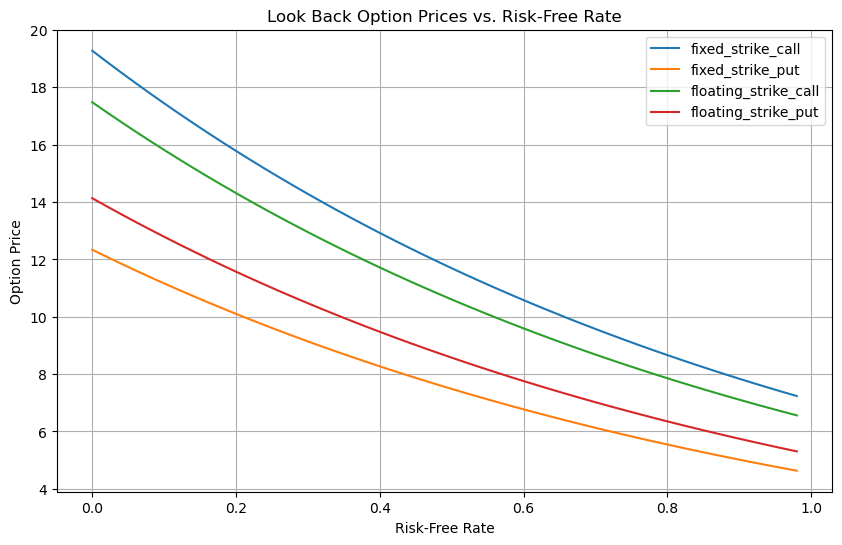

In [260]:
# Define function to calculate look back option prices
def look_back_option_prices(S, E, r, T, option_type):
    if option_type == 'fixed_strike_call':
        M_max_option = np.max(S, axis=0)
        option_price = exp(-r * T) * mean(maximum(0, M_max_option - E))
    elif option_type == 'fixed_strike_put':
        M_min_option = np.min(S, axis=0)
        option_price = exp(-r * T) * mean(maximum(0, E - M_min_option))
    elif option_type == 'floating_strike_call':
        M_min_option = np.min(S, axis=0)
        option_price = exp(-r * T) * mean(maximum(0, S[-1] - M_min_option))
    elif option_type == 'floating_strike_put':
        M_max_option = np.max(S, axis=0)
        option_price = exp(-r * T) * mean(maximum(0, M_max_option - S[-1]))
    else:
        option_price = None
        print("Invalid option type!")
    return option_price

# Define parameters and ranges
risk_free_rate_range = np.arange(0, 1, 0.02)
strike = 100
sigma = 0.2
E = 100
T = 1
n_sims = 100000
option_types = ['fixed_strike_call', 'fixed_strike_put', 'floating_strike_call', 'floating_strike_put']

# Store option prices
option_prices = {opt_type: [] for opt_type in option_types}

# Calculate option prices for different risk-free rates
for r in risk_free_rate_range:
    S = simulate_path(100, 0.05, 0.2, 1, 252, n_sims)
    for opt_type in option_types:
        option_price = look_back_option_prices(S, E, r, T, opt_type)
        option_prices[opt_type].append(option_price)

# Plot option prices
plt.figure(figsize=(10, 6))

for opt_type in option_types:
    plt.plot(risk_free_rate_range, option_prices[opt_type], label=opt_type)

plt.xlabel('Risk-Free Rate')
plt.ylabel('Option Price')
plt.title('Look Back Option Prices vs. Risk-Free Rate')
plt.legend()
plt.grid(True)
plt.show()

Observations: 1. As the risk-free rate increases, in terms of lookback option, the prices of both fixed strike and floating strike options gradually decrease. 2. This phenomenon may suggest a cautious sentiment towards higher risk-free rates in the market, as evidenced by the declining option prices. Investors may be more concerned about future risks, leading them to opt for more conservative investment strategies or adjust their risk exposure. This may also influence the choice of option pricing and trading strategies, requiring careful consideration of the impact of risk-free rates.

## 5 Problems encountered

When I was studying the impact of volatility on option prices in the design section, I initially set a very small range for volatility variations and found that option prices increased with increasing volatility. However, I noticed that the differences in their changes were not significant, which left me puzzled about whether I had written the code incorrectly. So, I set the maximum value of volatility to 50, but because of the large amount of data, this code took a long time to run. I observed that when volatility varied within a range of 1, option prices gradually increased, confirming that my initial code was correct. Finally, I limited the upper bound of volatility to 0.5.

## 6 Conclusion

In this report, we use Monte Carlo Simulation to explore and implement the Asian Option and the Lookback Option pricing.  In terms of asian options, we discusse both averaging methods (arithmetic average and geometric average) and from the experiment result, we find that there is no significant difference between them. Additionally, we both focus on of fixed strike opion and floating strike option of the Asian Option and the Lookback Option.  Finally, we try to vary the variables to see the affect on the option price.

Moreover, the option price shows different based on the different variables.  Some further research may be carried out in the future to find the dynamic optimization solution and the prediction in the more complex environment.

## 7 Reference

- [1] Paul Wilmott on Quantitative Finance Volume 2, Paul Wilmott, John Wiley & Sons Ltd., 2006, P428-P443, P445-P452
- [2] CQF Course M3 L1 - The Black–Scholes Model
- [3] CQF Course M3 L2 - Martingales Theory Application to Option Pricing
- [4] CQF Course M3 L3 - Martingales and PDEs Which When and Why
- [5] CQF Course M3 L5 - Exotic Options
- [6] CQF Course Python Lab6 - Monte Carlo Option Pricing
- [7] Ernst Eberlein, Antonis Papapantoleon - Equivalence of floating and fixed strike Asian and lookback options, [https://www.sciencedirect.com/science/article/pii/S0304414904001061]